In [ ]:
!git clone https://github.com/airtlab/ConvLSTM4AD # https://github.com/airtlab/ConvLSTM4AD

!gdown --id 1ke9LtG9S_Q-MpCeTe3WNtTR_mEQndJ1h -O ConvLSTM4AD/bestmodel.h5

#from google.colab import drive
#drive.mount('/content/drive')

Cloning into 'ConvLSTM4AD'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 471 (delta 12), reused 0 (delta 0), pack-reused 439
Receiving objects: 100% (471/471), 132.81 MiB | 56.22 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Downloading...
From: https://drive.google.com/uc?id=1ke9LtG9S_Q-MpCeTe3WNtTR_mEQndJ1h
To: /content/ConvLSTM4AD/bestmodel.h5
2.11GB [00:11, 190MB/s]


In [ ]:
!pip install simpleitk
import SimpleITK as sitk
import os
import nibabel as nib
import numpy as np

def resample_img(itk_image, out_spacing=[1, 1, 1], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(itk_image)

def preprocess(img, out_shape=None):
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    mean = img.mean() 
    std = img.std() 
    return (img - mean) / std

img_path = "/content/ConvLSTM4AD/Merged_dataset/Dataset"
img_height, img_width = 256, 256 
seq_len = 5

X = [] 
Y = [] 

dir = img_path 
classes = ["AD","CN"]  
classes_list = os.listdir(dir) 
classes_list.sort() 

full_path_AD = os.path.join(dir, classes_list[0]) 
samples_AD = os.listdir(full_path_AD) 
samples_AD.sort() 
for a in samples_AD: 
  b = os.path.join(full_path_AD, a) 
  my_img = nib.load(b) 
  nii_data = my_img.get_fdata() 
  my_img.uncache()
  del my_img
  temp = [] 
  for i in range(0,5): 
    temp.append(preprocess(nii_data[:,:,i]))
  X.append(temp) 
  y = [0]*len(classes_list)
  y[1] = 1 
  Y.append(y) 

full_path_CN = os.path.join(dir, classes_list[1]) 
samples_CN = os.listdir(full_path_CN) 
samples_CN.sort()
for a in samples_CN: 
  b = os.path.join(full_path_CN, a)
  my_img = nib.load(b) 
  nii_data = my_img.get_fdata() 
  my_img.uncache()
  del my_img
  temp = []
  for i in range(0,5): 
    temp.append(preprocess(nii_data[:,:,i]))
  X.append(temp)
  y = [0]*len(classes_list)
  y[0] = 1 
  Y.append(y) 

In [ ]:
X = np.asarray(X)
Y = np.asarray(Y)

X = X[...,np.newaxis]
print(X.shape)

(427, 5, 256, 256, 1)


In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

seed = 0 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, random_state=seed) 

print("Number of training samples: " + str(len(X_train)))
print("Number of test samples: " + str(len(X_test)))

del X
del Y

Number of training samples: 341
Number of test samples: 86


In [ ]:
#!pip show tensorflow
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras import models

model = tf.keras.models.load_model('/content/ConvLSTM4AD/bestmodel.h5') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 254, 254, 32)      38144     
_________________________________________________________________
dropout (Dropout)            (None, 254, 254, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 2064512)           0         
_________________________________________________________________
dense (Dense)                (None, 256)               528515328 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 528,553,986
Trainable params: 528,553,986
Non-trainable params: 0
__________________________________________

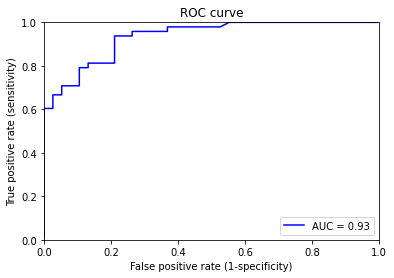

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

probs = model.predict(X_test)
preds = probs[:,1]

Y_test = np.argmax(Y_test, axis = 1)

fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'w--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True positive rate (sensitivity)')
plt.xlabel('False positive rate (1-specificity)')
plt.show()